In [1]:
import os, json
import numpy as np
import pandas as pd

import sklearn 
from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report
from sklearn_crfsuite import metrics

from feature.doccano2fully import *
from feature.svm_small_features import *


In [2]:
# the dataset input folder path
dataset_folder_path = 'data/input/'
# target labels
target_labels = ['type', 'brand', 'name']
# test_size
test_size = 0.3

#### Data Preparing
***

In [3]:
def clean_target_label(labels):
    targets = []
    converter = lambda label : label if label in target_labels else 'None'
    targets = [converter(label) for label in labels]
    return targets

In [4]:
#return seq_in, seq_out, words_labels
def data_extracting(data_lines, id):
    pcontents = []
    for line in data_lines:
        line = doccano2fully(line)
        text, labels, words, tagged = extract_fully_data(line)
        labels = clean_target_label(labels)
        if tagged:
            pcontents.append((id, tagged, words, labels))
            id += 1

    return pcontents

In [5]:
def file2dataset(input_file_name):
    input_file_path = dataset_folder_path + input_file_name
    input_file = open(input_file_path, "r", encoding = "utf8")
    
    data_lines = input_file.readlines()
    input_file.close()
    
    id = 1
    pcontents = data_extracting(data_lines, id)

    # split to training set and testing set
    indices = np.arange(len(pcontents))
    train_small, test_small, idx1, idx2 = train_test_split(pcontents, indices, test_size=test_size, random_state=42)
    
    return train_small, test_small

In [12]:
# list of input files
input_files = os.scandir(dataset_folder_path)
input_file_names = [input_file.name for input_file in input_files]

# dataset preparing
train_set = []
test_set = []

for input_file_name in input_file_names:
    train_small, test_small = file2dataset(input_file_name)
    train_set += train_small
    test_set += test_small

print("Train set: ", len(train_set))
print("Test set: ", len(test_set))

Train set:  524
Test set:  225


In [13]:
%%time
# do split traint/test set
# count of rows which
fex = FE_W0()
fec= FeatureExtractionContainer()

# Arrange trainig and test set
fec= FeatureExtractionContainer()
train_set_feature= fec.process_sentenses(train_set)
test_set_feature= fec.process_sentenses(test_set, False)

df_train = fec.features_pandalizer(train_set_feature)
df_test = fec.features_pandalizer(test_set_feature)


Wall time: 14.1 s


#### Training and Testing
***

In [15]:
def multiSVM_training(all_labels, df_train):
    # mutil_model per labels
    cls_per_ner = {}
    
    # training result
    df_train_result = df_train.loc[:, ['TupleID', 'word','Tag']].copy()
    df_train_result = df_train_result.reindex(columns=df_train_result.columns.tolist() + all_labels)
    
    for label in all_labels:
        df_train_copy = df_train.loc[:].copy()
        df_train_copy['Y'] = df_train_copy.apply(lambda row: (1 if row['Tag'] == label else 0), axis=1)
        df_train_copy.drop(['word', 'WordID', 'Tagged', 'TupleID', 'Tag'], axis=1, inplace=True)
        
        # dataset
        X_train = df_train_copy.drop('Y', axis=1)
        Y_train = df_train_copy['Y']
        
        # model
        svc = SVC(kernel='rbf', gamma=0.7, probability=True)

        # training
        clf = svc.fit(X_train, Y_train)
        cls_per_ner[label] = clf

        # predict
        y_pred = clf.predict(X_train)
        y_pred_porbability = clf.predict_proba(X_train)
        df_train_result[label] = y_pred_porbability[:,1]
        

    return df_train_result, cls_per_ner

In [16]:
def multiSVM_testing(all_labels, df_test, cls_per_ner):
    #testing result
    df_test_result = df_test.loc[:, ['TupleID', 'word','Tag']].copy()
    df_test_result = df_test_result.reindex(columns=df_test_result.columns.tolist() + all_labels)

    for label in all_labels:
        df_test_copy = df_test.copy()
        df_test_copy['Y'] = df_test_copy.apply(lambda row: (1 if row['Tag'] == label else 0), axis=1)
        df_test_copy.drop(['word', 'WordID', 'Tagged', 'TupleID', 'Tag'], axis=1, inplace=True)

        # dataset
        X_test = df_test_copy.drop('Y', axis=1)
        Y_test = df_test_copy['Y']
        
        # predict
        clf = cls_per_ner[label]
        y_pred = clf.predict(X_test)
        y_pred_porbability = clf.predict_proba(X_test)
        df_test_result[label] = y_pred_porbability[:,1]

    return df_test_result

In [17]:
%%time
#training
all_labels = target_labels + ['None']
df_train_result, cls_per_ner = multiSVM_training(all_labels, df_train)

Wall time: 45min 19s


In [18]:
%%time
# testing
df_test_result = multiSVM_testing(all_labels, df_test, cls_per_ner)

Wall time: 4min 52s


In [19]:
# Label Predict From Threshold and Label Probabilitys
def calc_tag(row):
    maxi = np.argmax([row[name] for name in all_labels])
    maxval = row[all_labels[maxi]]
    if prob_threshold < maxval:
        return all_labels[maxi]
    return ''

# Print Metrics Report
def print_metrics(df_result, target_labels):
    df_result['TagPred'] = df_result.apply(calc_tag, axis=1)
    df_result.head(20)

    # collect results in list of lists
    list_tag = []
    list_tag_pred = []
    list_list_tag_pred = []
    list_list_tag = []
    prev_tuple = -1
    for index, row in df_result.iterrows():
        tupleId = row['TupleID']
        tag = row['Tag']
        tag_pred = row['TagPred']
        if len(list_tag) > 0 and prev_tuple != tupleId:
            list_list_tag.append(list_tag)
            list_list_tag_pred.append(list_tag_pred)
            list_tag = []
            list_tag_pred = []
        list_tag.append(tag)
        list_tag_pred.append(tag_pred)
        prev_tuple = tupleId
    list_list_tag.append(list_tag)
    list_list_tag_pred.append(list_tag_pred)
        
    #print(list_list_tag)
    print(metrics.flat_classification_report(
        list_list_tag, list_list_tag_pred, labels=target_labels, digits=3
    ))

In [20]:
prob_threshold = 0.4

# Train metrics
print("# Training metrics")
print_metrics(df_train_result, target_labels)

# Test metrics
print("# Testing metrics")
print_metrics(df_test_result, target_labels)

# Training metrics


C:\Users\Green\miniconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['type', 'brand', 'name'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

        type      0.941     0.841     0.888      1513
       brand      0.976     0.946     0.961       299
        name      0.992     0.947     0.969       513

   micro avg      0.957     0.878     0.916      2325
   macro avg      0.970     0.912     0.939      2325
weighted avg      0.957     0.878     0.915      2325

# Testing metrics
              precision    recall  f1-score   support

        type      0.829     0.771     0.799       597
       brand      0.911     0.293     0.443       140
        name      0.807     0.288     0.424       233

   micro avg      0.832     0.586     0.687       970
   macro avg      0.849     0.450     0.555       970
weighted avg      0.836     0.586     0.657       970



In [21]:
# Confusion matric
print('# Confusion matix')
sklearn.metrics.confusion_matrix(df_test_result['Tag'], df_test_result['TagPred'], labels=all_labels)

# Confusion matix


array([[ 460,    0,    1,  108],
       [  10,   41,    3,   60],
       [   3,    3,   67,  136],
       [  82,    1,   12, 2064]], dtype=int64)

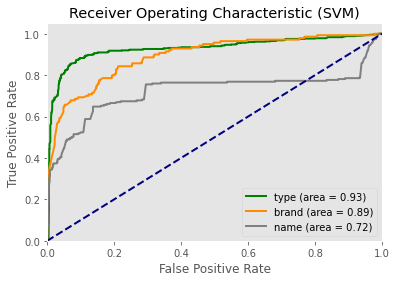

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Receiver Operating Characteristic - ROC

fpr = {}
tpr = {}
roc_auc = {}
colors = {'type' : 'green', 'brand' : 'darkorange', 'name' : 'grey'}
for label in target_labels:
    fpr[label], tpr[label], _ = sklearn.metrics.roc_curve(y_true=list((df_test_result['Tag'] == label).astype(int)), 
                                  y_score=df_test_result[label].astype(float), pos_label=1)
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure()
lw = 2
for label in target_labels:
    plt.plot(fpr[label], tpr[label], color=colors[label],
             lw=lw, label='%s (area = %0.2f)' % (label,roc_auc[label]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (SVM)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [23]:
df_test_result

,TupleID,word,Tag,type,brand,name,None,TagPred
0,143,bàn,type,0.935700,0.023179,0.031588,0.067010,type
1,143,ủi,type,0.935592,0.022659,0.031660,0.067060,type
2,143,hơi,None,0.057232,0.023062,0.028181,0.914362,None
3,143,nước,None,0.057229,0.023034,0.031652,0.914363,None
4,143,công,None,0.057281,0.023060,0.031620,0.914431,None
...,...,...,...,...,...,...,...,...
3176,238,hàng,None,0.057282,0.023107,0.031529,0.914384,None
3177,238,nội,None,0.057193,0.023082,0.031559,0.914437,None
3178,238,địa,None,0.057233,0.023041,0.031653,0.914362,None
3179,238,trung,None,0.057258,0.023123,0.031598,0.914485,None
